In [49]:
import sys, os
import numpy as np
sys.path.append('../src/')
import torch
from mgnn.MolGraphNetwork import MolGraphNetwork
from utils import find_repo_root
from scf_guess_tools import Backend
from scf_guess_datasets import Qm9
import scf_guess_datasets
from utils import plot_mat_comp


project_root_dir = find_repo_root()
print("Project root directory:", project_root_dir)
BASIS_PATH = "../../../scripts/6-31g_2df_p_custom_nwchem.gbs"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)
#Current best trial: ebffc_00023 with loss=3.290987253189087 and params={'batch_size': 16, 'hidden_dim': 512, 'message_passing_steps': 6, 'edge_threshold_val': 1., 'message_net_dropout': 0.09772288864576731, 'dat5122788896881607a_aug_factor': 1.0, 'message_net_layers': 5, 'lr': 0.0003257920597967229, 'weight_decay': 3.460137919135933e-06, 'num_epochs': 50, 'grace_epochs': 5, 'lr_factor': 0.5, 'lr_patience': 3, 'lr_threshold': 0.001, 'lr_cooldown': 2, 'lr_min': 1e-06}



local_pc_path = os.path.join(project_root_dir, "datasets/QM9") if str(device) != "cuda" else "/home/dmilacher/datasets/data1"
dataset = Qm9(
    local_pc_path, 
    size = 500, # number of molecules to load
    val=0.1, # using 80% training / 10 % val / 10% test split
    test=0.1
)

Project root directory: /home/etschgi1/REPOS/Masterarbeit
Using device: cpu


In [50]:
from BlockMatrix import *
def addtoavgdict(mat, symbol, dict_): 
    try: 
        cur_state = dict_[symbol]
        dict_[symbol] = (cur_state[0]+mat, cur_state[1]+1)
    except KeyError: 
        dict_[symbol] = (mat, 1)

In [51]:
averages = {}
for train_key in dataset.train_keys: 
    mol = dataset.molecule(train_key)
    atom_slices = mol.aoslice_by_atom()
    n_atoms = len(atom_slices)
    T = dataset.solution(train_key).density
    # centers
    for atom_index in range(n_atoms):
            _, _, ao_start, ao_end = atom_slices[atom_index]
            # train target center
            T_center = T[ao_start:ao_end, ao_start:ao_end]
            addtoavgdict(T_center, mol.atom_symbol(atom_index), averages)
    # edges
    for i in range(n_atoms): 
            _, _, ai_start, ai_stop = atom_slices[i]
            n_i = ai_stop - ai_start
            for j in range(i + 1, n_atoms): # +1 to skip center blocks
                _, _, aj_start, aj_stop = atom_slices[j]
                n_j = aj_stop - aj_start

                T_block = T[ai_start:ai_stop, aj_start:aj_stop]
                edge_key = "_".join([mol.atom_symbol(i), mol.atom_symbol(j)])
                addtoavgdict(T_block, edge_key, averages)

In [52]:
def writeavg(dict_): 
    out = {}
    for key, val in dict_.items():
        out[key] = val[0] / val[1]
    return out
averages = writeavg(averages)

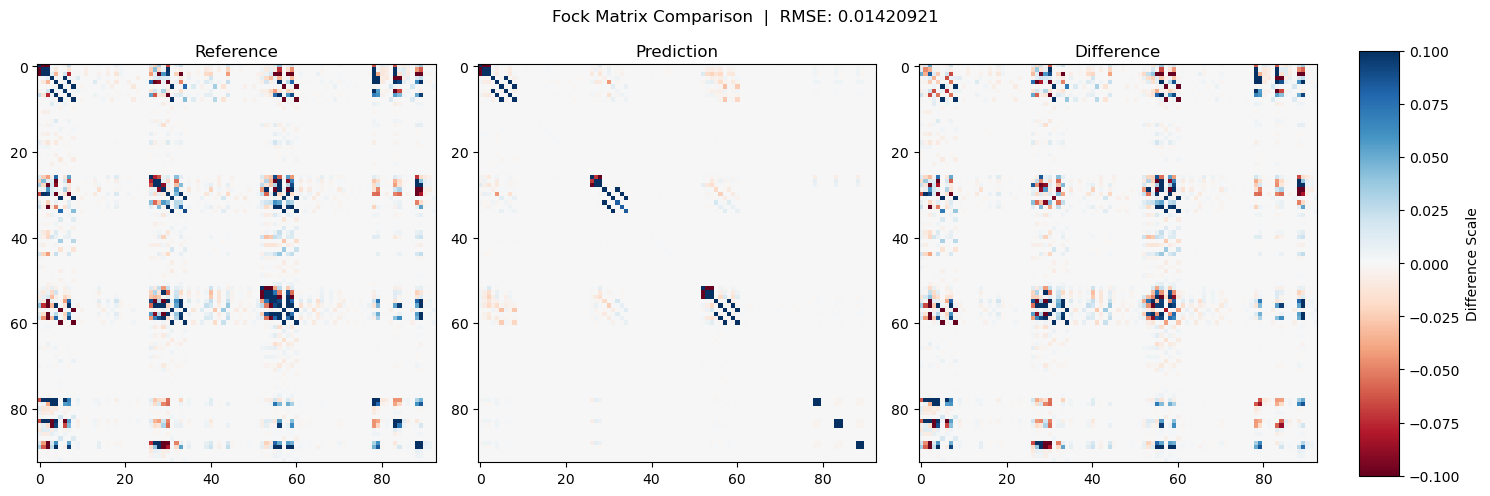

In [53]:
def build_pred(mol, avg_dict_): 
    atom_slices = mol.aoslice_by_atom()
    n_atoms = len(atom_slices)
    pred = np.zeros((mol.nao, mol.nao))
    # populate centers
    for atom_index in range(n_atoms):
        _, _, ao_start, ao_end = atom_slices[atom_index]
        pred[ao_start:ao_end, ao_start:ao_end] = avg_dict_[mol.atom_symbol(atom_index)]
    # populate edges
    for i in range(n_atoms): 
        _, _, ai_start, ai_stop = atom_slices[i]
        for j in range(i + 1, n_atoms): # +1 to skip center blocks
            _, _, aj_start, aj_stop = atom_slices[j]
            edge_key = "_".join([mol.atom_symbol(i), mol.atom_symbol(j)])
            pred[ai_start:ai_stop, aj_start:aj_stop] = avg_dict_[edge_key]
            pred[aj_start:aj_stop, ai_start:ai_stop] = avg_dict_[edge_key].T
    return pred

i = 36
test_mol = dataset.molecule(dataset.test_keys[i])
pred_t0 = build_pred(test_mol, averages)
sol_t0 = dataset.solution(dataset.test_keys[i]).density
plot_mat_comp(sol_t0, pred_t0, vmax=0.1)


# Benchmark stuff for dummy

In [60]:
from eval_res import build_fock_from_density, energy_elec, energy_err, diis_rmse, create_mf_from_mol

### Predictions

In [61]:
density_preds =  [build_pred(mol, averages) for mol in [dataset.molecule(i) for i in dataset.test_keys]]

### Focks from density

In [62]:
pred_focks = []
pred_overlaps = []
coreHs = []
for i, (pred_density, key) in enumerate(zip(density_preds, dataset.test_keys)):
        cur_mol = dataset.molecule(key)
        mf = create_mf_from_mol(cur_mol, xc="b3lypg")
        pred_focks.append(build_fock_from_density(mf, pred_density))
        pred_overlaps.append(mf.get_ovlp())
        coreHs.append(mf.get_hcore())

### Energy

In [84]:
abs_errs, rel_errs = [], []
for density, fock, coreH, key in zip(density_preds, pred_focks, coreHs, dataset.test_keys):
    e_conv = energy_elec(dataset.solution(key).fock, dataset.solution(key).density, dataset.solution(key).hcore)
    e_pred = energy_elec(fock, density, coreH)
    abs_err, rel_err = energy_err(e_pred, e_conv)
    abs_errs.append(abs_err)
    rel_errs.append(rel_err)
print(f"Abs error: {np.mean(np.array(abs_errs))} +- {np.std(np.array(abs_errs))}")
print(f"Rel error: {np.mean(np.array(rel_errs))} +- {np.std(np.array(rel_errs))}")


Abs error: -807.671795580121 +- 199.03840742390483
Rel error: -0.5160587510064246 +- 0.022512793947948747


### DIIS

In [ ]:
diis = []
for overlap, density, fock in zip(pred_overlaps, density_preds, pred_focks): 
    diis.append(diis_rmse(overlap, density, fock))
print(f"DIIS error: {np.mean(np.array(diis))} +- {np.std(np.array(diis))}")

DIIS error: 0.10692063564557133 +- 0.024313667531220974


### RMSE

In [86]:
rmse = []
for density, key in zip(density_preds, dataset.test_keys): 
    rmse.append(np.sqrt(np.mean((density - dataset.solution(key).density)**2)))
print(f"RMSE error: {np.mean(np.array(rmse))} +- {np.std(np.array(rmse))}")

RMSE error: 0.01437353436066504 +- 0.0026222485847284143


### Iterations

In [91]:
it = []
for density, key in zip(density_preds, dataset.test_keys): 
    solver = dataset.solver(key)
    _, _, _, _, status = scf_guess_datasets.solve(solver, density.astype(np.float64))
    print(status.iterations)
    it.append(status.iterations)

19
17
18
16
16
17
17
17
18
14
15
15
16
20
17
17
18
17
17
16
18
18
17
17
18
17
15
17
20
18
25
21
14
19
17
16
10
15
11
12
17
26
17
17
12
19
17
19
19
18


In [92]:
print(f"Iterations: {np.mean(np.array(it))} +- {np.std(np.array(it))}")

Iterations: 17.06 +- 2.7597826001335686


In [93]:
it

[19,
 17,
 18,
 16,
 16,
 17,
 17,
 17,
 18,
 14,
 15,
 15,
 16,
 20,
 17,
 17,
 18,
 17,
 17,
 16,
 18,
 18,
 17,
 17,
 18,
 17,
 15,
 17,
 20,
 18,
 25,
 21,
 14,
 19,
 17,
 16,
 10,
 15,
 11,
 12,
 17,
 26,
 17,
 17,
 12,
 19,
 17,
 19,
 19,
 18]